<a href="https://colab.research.google.com/github/Jesusgsc29/Lung-Cancer-AI-Model/blob/main/Jesus_Sanchez_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1

In this project, you will develop a deep learning model to classify lung nodules as benign or malignant from 3D CT scans, utilizing the LUNA16 dataset. This task involves data preprocessing, model design, training, and evaluation, offering hands-on experience with medical image analysis and deep learning in PyTorch.

## 1. Create Annotation Data
As the first step, we will need to load the annotation data from Kaggle's data page: [Luna 16 Lung Cancer Dataset on Kaggle](https://www.kaggle.com/datasets/fanbyprinciple/luna-lung-cancer-dataset)

1.1 Download the annotation dataset from Kaggle.

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d 'fanbyprinciple/luna-lung-cancer-dataset'
! unzip -q luna-lung-cancer-dataset.zip -d luna16

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/fanbyprinciple/luna-lung-cancer-dataset
License(s): CC-BY-SA-3.0
 98% 325M/330M [00:02<00:00, 143MB/s]
100% 330M/330M [00:02<00:00, 118MB/s]


1.2 Load the `candidates_V2.csv` file as a data frame. Display the first 5 rows.

In [ ]:
! pip install SimpleITK
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SimpleITK as sitk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 11.2 MB/s eta 0:00:00


In [ ]:
candidates = pd.read_csv('luna16/candidates_V2/candidates_V2.csv')
annotations = pd.read_csv("luna16/annotations.csv")

candidates.head()

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,68.420000,-74.480000,-288.700000,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-95.209361,-91.809406,-377.426350,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-24.766755,-120.379294,-273.361539,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-63.080000,-65.740000,-344.240000,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,52.946688,-92.688873,-241.067872,0


In [ ]:
annotations.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


1.3 Display the number of class 0 (benign) records and the number of class 1 (malignant) records. Your results should indicate that the two classes are highly imbalanced.

In [ ]:
# Display the number of in each class
candidates['class'].value_counts()

,count
class,
0,753418
1,1557


## 2. Find Nodule Locations
In the annotation dataset, the center of each identified lung nodule is marked with its 3D coordinates. We need to convert these coordinates into three indices to identify the specific subarray in each CT scan tensor that corresponds to the nodule.

Please follow the steps outlined in the LUNA16DataPreparation notebook to generate a CSV file named `candidates_processed.csv`, which will store the indices for the center of each lung nodule.

2.1 Load the `subset0.zip` from Google Drive using the file ID '1OFa8UhDvCrcTj1VkFLa7RjifEqMD4TAa'. Extract the zip file to reveal the .mhd and .raw files.

In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id='1OFa8UhDvCrcTj1VkFLa7RjifEqMD4TAa'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('subset0.zip')

! unzip -q subset0.zip

2.2 Create a Pandas data frame that contains these 8 colums: `seriesuid`, `coordX`, `coordY`, `coordZ`, `class`, `index`, `row`, `col`. The last three columns should be calculated using the three coordiantes and the information about the origin and spacing of the corresponding CT scan.

In [ ]:

# Extract UIDs from files in subset0 folder
all_mhd = glob.glob('subset0/*.mhd')
name = all_mhd[0]
start_index = name.find('1.')
end_index = name.find('.mhd')
# print(start_index, end_index)
print("ID:", name[start_index:end_index])
ids = [name[start_index:end_index] for name in all_mhd]
print("ID list:", ids)

samples = candidates[(candidates['class'] == 1) &
           (candidates['seriesuid'].isin(ids))].sample(5)
samples

ID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304
ID list: ['1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304', '1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488', '1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490', '1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145', '1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114', '1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896088956784723476543', '1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720', '1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732', '1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523', '1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074', '1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998', '1.3.6.1.4.1.14519.5.2.1.6279.6001.640729228179368154416184318668', '1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950', '1.3.6.1.4.1.14519.5.2.1.6279.6001.12

,seriesuid,coordX,coordY,coordZ,class
216605,1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205...,94.868249,-22.415258,-208.030982,1
522984,1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725...,-103.694873,5.239206,-44.551284,1
64831,1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931...,59.373537,-157.994313,-119.056834,1
90972,1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843...,-120.470000,176.870000,-531.390000,1
307504,1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224...,119.271739,20.088898,-154.548441,1


In [ ]:
# Create a dataset containing the origin, spacing, and direction information for each CT scan
num_rows = len(ids)
ct_info = pd.DataFrame(np.zeros([num_rows, 6]), columns=['originX', 'originY', 'originZ', 'spacingX', 'spacingY', 'spacingZ'], index=ids)
ct_info.head()

for id in ids:
    mhd_path = 'subset0/{}.mhd'.format(id)
    ct_mhd = sitk.ReadImage(mhd_path)
    ct_info.loc[id, ['originX', 'originY', 'originZ']] = list(ct_mhd.GetOrigin())
    ct_info.loc[id, ['spacingX', 'spacingY', 'spacingZ']] = list(ct_mhd.GetSpacing())
    if ct_mhd.GetDirection() != (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0):
        print(id, ct_mhd.GetDirection())
print(ct_info.shape)
ct_info.head()

1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820 (0.9999999999999999, 0.0, 0.0, 0.0, 0.9999999999999999, 0.0, 0.0, 0.0, 1.0)
1.3.6.1.4.1.14519.5.2.1.6279.6001.826812708000318290301835871780 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.9999999999999999)
1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223 (0.9999999999999999, 0.0, 0.0, 0.0, 0.9999999999999999, 0.0, 0.0, 0.0, 1.0)
1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.9999999999999999)
1.3.6.1.4.1.14519.5.2.1.6279.6001.657775098760536289051744981056 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.9999999999999999)
1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557 (0.9999999999999999, 0.0, 0.0, 0.0, 0.9999999999999999, 0.0, 0.0, 0.0, 1.0)
1.3.6.1.4.1.14519.5.2.1.6279.6001.310626494937915759224334597176 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.9999999999999999)
(89, 6)


,originX,originY,originZ,spacingX,spacingY,spacingZ
1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304,-153.500000,-177.399994,-310.250000,0.654297,0.654297,1.250
1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488,-182.399994,-187.100006,-382.500000,0.781250,0.781250,2.500
1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490,-188.800003,-196.600006,-279.095001,0.703125,0.703125,0.625
1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145,-165.000000,-165.000000,-42.500000,0.644531,0.644531,2.500
1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114,-183.600006,-162.899994,-335.250000,0.703125,0.703125,2.500


In [ ]:
# Define a uniform direction vector for all CT scans
direction_a = np.array([1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]).reshape(3, 3)
print(direction_a)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [ ]:
count = 0

# Extract the nodule from the supported CT scans.
candidates_small = candidates[candidates['seriesuid'].isin(ids)]
print(len(candidates_small))

for idx in candidates_small.index: # Go through all nodules supported by the CT scan data

    # Extract the coordinates of the nodule
    coordX, coordY, coordZ = candidates_small.loc[idx, ['coordX', 'coordY', 'coordZ']]

    # Extract the corresponding CT scan ID.
    id = candidates_small.loc[idx, 'seriesuid']

    # Convert the coordiates to indices
    origin_a = ct_info.loc[id, ['originX', 'originY', 'originZ']].values.reshape([-1])
    vxSize_a = ct_info.loc[id, ['spacingX', 'spacingY', 'spacingZ']].values.reshape([-1])
    coord_a = np.array([coordX, coordY, coordZ])
    cri_a = ((coord_a - origin_a) @ np.linalg.inv(direction_a)) / vxSize_a
    cri_a = np.round(cri_a)

    # Record the indices to the data frame
    candidates_small.loc[idx, 'index'] = int(cri_a[2])
    candidates_small.loc[idx, 'row'] = int(cri_a[1])
    candidates_small.loc[idx, 'col'] = int(cri_a[0])

    count += 1
    if count % 1000 == 0:
        print(count)

79135


<ipython-input-12-3d5f527e3a8f>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates_small.loc[idx, 'index'] = int(cri_a[2])
<ipython-input-12-3d5f527e3a8f>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates_small.loc[idx, 'row'] = int(cri_a[1])
<ipython-input-12-3d5f527e3a8f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000


In [ ]:
candidates_small.dtypes


,0
seriesuid,object
coordX,float64
coordY,float64
coordZ,float64
class,int64
index,float64
row,float64
col,float64


In [ ]:
# Convert the indices to integers
candidates_small = candidates_small.copy() # remove the connection between candidates and candidates_small
candidates_small[['index', 'row', 'col']] = candidates_small[['index', 'row', 'col']].astype(int)

candidates_small.head()

,seriesuid,coordX,coordY,coordZ,class,index,row,col
11673,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-66.383107,57.143607,-60.885862,0,110,331,173
11674,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-132.856859,23.813034,-274.350845,0,24,287,86
11675,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,84.770000,66.170000,-249.880000,0,34,343,371
11676,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,134.805360,29.696241,-268.116009,0,27,295,437
11677,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-87.092676,41.722383,-208.831394,0,51,311,146


2.3 Save the data frame as a CSV file named `candiadates_processed.csv`. This allows you to skip Step 2.2 in future calculations.




In [ ]:
candidates_small.to_csv('candidates_processed.csv', index=False)

In [ ]:
# Save to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive

 0+1,6,-36,216.pdf		 'Jesus_Sanchez Caceres_Resume.docx'
 20190320_101256.jpg		 'LTS 242.gdoc'
 candidates_processed.csv	 'Metodo Guitarra Clasica - Mateo Carcassi.pdf'
 Classroom			 'Trabajo sobre la lectura y el párrafo.gdoc'
'Colab Notebooks'		 'Trabajo sobre la lectura y el párrafo.pdf'
 ct_info.csv			 'Trio - Malagueña.pdf'
'Documento sin título (1).gdoc'   Yo
'Documento sin título.gdoc'	 'Zoom Meeting 2022-05-12 17-19-57.mp4'
'English 111 Class '		 'Zoom Meeting 2022-05-12 17-34-00.mp4'


In [ ]:
candidates_small.to_csv('drive/MyDrive/candidates_processed.csv', index=False)

In [ ]:
data = pd.read_csv('drive/MyDrive/candidates_processed.csv')
data.head()

,seriesuid,coordX,coordY,coordZ,class,index,row,col
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-66.383107,57.143607,-60.885862,0,110,331,173
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-132.856859,23.813034,-274.350845,0,24,287,86
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,84.770000,66.170000,-249.880000,0,34,343,371
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,134.805360,29.696241,-268.116009,0,27,295,437
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-87.092676,41.722383,-208.831394,0,51,311,146


In [ ]:
# Also save the ct_info data frame.
ct_info.to_csv("drive/MyDrive/ct_info.csv") # Keep index=True to store the indices
temp = pd.read_csv("drive/MyDrive/ct_info.csv", index_col=0) # Set the first column to be the indices
temp.head()

,originX,originY,originZ,spacingX,spacingY,spacingZ
1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304,-153.500000,-177.399994,-310.250000,0.654297,0.654297,1.250
1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488,-182.399994,-187.100006,-382.500000,0.781250,0.781250,2.500
1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490,-188.800003,-196.600006,-279.095001,0.703125,0.703125,0.625
1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145,-165.000000,-165.000000,-42.500000,0.644531,0.644531,2.500
1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114,-183.600006,-162.899994,-335.250000,0.703125,0.703125,2.500


## 3. Create Data Tensors

The neural network model we will build with PyTorch requires the data to be presented in the form of a torch tensor. The input tensor should be 4-dimensional, with the dimensions representing the nodule index, channel, row, and column, respectively.

3.1 Write a double for-loop to extract the CT scan data for **the first 5,000*** nodules:
- The outer for loop goes through all the distince seriesuid's.
- For each iteration of the outer loop, load the corresponding CT-scan file and create a torch tensor to represent the scan.
- Create an inner-loop that goes through the nodules corresponding to the seriesuid:
    - Load the (index, row, col) tuple of this nodule from the data frame.
    - Extract a 32x48x48 chunk centered at the (index, row, col). If the nodule is near the edge of the image and there is not enough indices to extract, please pad with zeros to keep the overall shape unchanged.
    - Use a 4D tensor to contain all the 32x48x48 chunks. The first dimension of the 4D tensor is the index of nodule.

You may modify the above procedure as you like. Make sure that you are able to obtain a 4D tensor that contains all nodule data. **Display the shape of the 4D tensor.** The shape of the tensor should be (5000, 32, 48, 48).

**Remark** Due to the memory limit, it is impossible to load all nodule images into simultanously. Therefore, the number of nodules required in this section is reduced to 5,000. Feel free to adjust this number to prevent the out-of-memory error.

In [ ]:
import torch

num_nodules = 5000

# Build an empty input tensor and an empty output tensor
chunks = torch.zeros([num_nodules, 32, 48, 48])
labels = torch.zeros([num_nodules])

In [ ]:
# # Approach 2: Create the 4D tensor with each file being loaded once.

# create a for loop to go through all CT scan files.
all_files = glob.glob('subset0/*.mhd')

count = 0
# Professor I have a problem here, I dont understand why it doesn't want to enter the for loop. The first time it worked, Now it doesn't
for file in all_files:

    print(file)
    # Load the file as an array
    ct_mhd = sitk.ReadImage(file)
    ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
    ct_a = ct_a.clip(-1000, 1000, ct_a)

    # Extract the ID from the file name.
    start_index = file.find('1.')
    end_index = file.find('.mhd')
    id = file[start_index:end_index]

    # for each CT scan load nodules from it.
    nodules = data[data['seriesuid'].str.contains(id)]

    # print(nodules.index)

    # Loop through these nodules and create a subarray for each one.
    for nodule_index in nodules.index:
        # Extract the indices for the center
        index, row, col = data.loc[nodule_index, ["index", "row", "col"]]

        # Build a 32x48x48 tensor to represent the nodule.
        # We need to add 0s if the nodule is too close to the boundary
        ct_chunk = torch.zeros([32, 48, 48])
        chunk = ct_a[(index-16):(index+16), (row-24):(row+24), (col-24):(col+24)]
        chunk_indices, chunk_rows, chunk_cols = chunk.shape
        ct_chunk[:chunk_indices, :chunk_rows, :chunk_cols] = torch.tensor(chunk)
        if chunk.shape[0] < 32:
            print("Padding on the first dimension is applied.")
        elif chunk.shape[1] < 48:
            print("Padding on the second dimension is applied.")
        elif chunk.shape[2] < 48:
            print("Padding on the third dimension is applied.")

        # Add this 3D tensor to the 4D tensor.
        chunks[count, :, :, :] = ct_chunk

        # Add the corresponding label to the label tensor
        labels[count] = data.loc[nodule_index, 'class']

        count += 1
        print(count)
        if count == num_nodules - 1:
            break # break out of the inner loop
    if count == num_nodules - 1:
        break # break out of the outer loop

Se han truncado las últimas 5000 líneas del flujo de salida.
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
Padding on the first dimension is applied.
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
29

In [ ]:
chunks.shape

torch.Size([5000, 32, 48, 48])

3.2 Create a 1D tensor to contain all the class information.

In [ ]:
labels.shape

torch.Size([5000])

3.3 Split the 4D tensor into a training set and a test set. Display their shapes.

In [ ]:
from sklearn.model_selection import train_test_split
chunks_train, chunks_test, labels_train, labels_test = train_test_split(chunks, labels, test_size=0.2)
print(chunks_train.shape, labels_train.shape)
print(chunks_test.shape, labels_test.shape)

torch.Size([4000, 32, 48, 48]) torch.Size([4000])
torch.Size([1000, 32, 48, 48]) torch.Size([1000])


## 4. Model Design and Implementation

4.1 Design a neural network model with only a flatten layer and two dense layers for classifying lung nodules. You may experiment with different sizes for the hidden layers to improve the training results.

In [ ]:
import torch.nn as nn
import torch.optim as optim

number_input_values = 32 * 48 * 48

model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(number_input_values, 2),
            nn.LogSoftmax(dim=1)) # Softmax produces probabilities as output
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=73728, out_features=2, bias=True)
  (2): LogSoftmax(dim=1)
)


In [ ]:
# Turn the dataset into a dataloader
dataset = torch.utils.data.TensorDataset(chunks_train, labels_train)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                           shuffle=True)

4.2 Create an object to represent the loss function.

In [ ]:
loss_fn = nn.NLLLoss()

4.3 Create an object to represent the optimizer.

In [ ]:
learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

4.4 Create a function to represent the training loop.


In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):

  for epoch in range(n_epochs):
      for img, label in train_loader:
          out = model(img)
          loss = loss_fn(out, label.long()) # label.long() represents the 0/1 labels as long integers

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

4.5 Execute the training loop. Display the change of training loss during the training process. Choose a reasonable value for the number of training epochs based on your observations.

In [ ]:
training_loop( 50, optimizer, model, loss_fn, train_loader)

Epoch: 0, Loss: 0.000000
Epoch: 1, Loss: 230664.687500
Epoch: 2, Loss: 0.000000
Epoch: 3, Loss: 0.000000
Epoch: 4, Loss: 0.000000
Epoch: 5, Loss: 0.000000
Epoch: 6, Loss: 0.000000
Epoch: 7, Loss: 0.000000
Epoch: 8, Loss: 0.021596
Epoch: 9, Loss: 0.000000
Epoch: 10, Loss: 0.000000
Epoch: 11, Loss: 0.000000
Epoch: 12, Loss: 0.000000
Epoch: 13, Loss: 0.000000
Epoch: 14, Loss: 0.000000
Epoch: 15, Loss: 0.000000
Epoch: 16, Loss: 0.000000
Epoch: 17, Loss: 0.000000
Epoch: 18, Loss: 0.000000
Epoch: 19, Loss: 0.000000
Epoch: 20, Loss: 0.000000
Epoch: 21, Loss: 0.000000
Epoch: 22, Loss: 0.000000
Epoch: 23, Loss: 0.000000
Epoch: 24, Loss: 0.000000
Epoch: 25, Loss: 0.000000
Epoch: 26, Loss: 0.000000
Epoch: 27, Loss: 0.000000
Epoch: 28, Loss: 0.000000
Epoch: 29, Loss: 0.000000
Epoch: 30, Loss: 0.000000
Epoch: 31, Loss: 0.000000
Epoch: 32, Loss: 0.000000
Epoch: 33, Loss: 0.000000
Epoch: 34, Loss: 0.000000
Epoch: 35, Loss: 0.000000
Epoch: 36, Loss: 0.000000
Epoch: 37, Loss: 0.000000
Epoch: 38, Loss: 

## 5. Model Evaluation and Analysis

5.1 Obtain the model's prediction on the test set.

In [ ]:
# Create a data loader for the test set.
dataset = torch.utils.data.TensorDataset(chunks_test, labels_test)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                           shuffle=True)

In [ ]:
# Apply the model to the test set.
probabilities = model(chunks_test)
probabilities

tensor([[        0., -24933984.],
        [        0., -20385436.],
        [        0., -44754848.],
        ...,
        [        0., -16822440.],
        [        0., -27634940.],
        [        0., -32290446.]], grad_fn=<LogSoftmaxBackward0>)

In [ ]:
# Turn the probabilites into class predictions
_, predictions = torch.max(probabilities, dim=1)
predictions[:25]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])

5.2 Calculate the report the following metrics:
- accuracy
- precision
- recall

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
acc = accuracy_score(labels_test, predictions)
precision = precision_score(labels_test, predictions)
recall = recall_score(labels_test, predictions)
print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.996
Precision: 0.0
Recall: 0.0


In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(labels_test, predictions)
print(mat)

[[996   2]
 [  2   0]]


5.3: Discuss the model's performance.

In [ ]:
# The model have a poor performance. it was a precision of 0 and a recall of 0, givin almost always a class of 0

## 6. Data Augmentation and Retraining

To enhance the model's performance, it is essential to increase the number of malignant instances. Apply random shifting and rotation to generate new training instances, ensuring an equal number of instances in each class within the training set.

6.1 Augment the number of malignent instances in the training set.

In [ ]:
# Example: Find one positive instance
data_positive = data[data['class'] == 1]
print("Total number of positive instances:", len(data_positive))
data_positive.head(10)

Total number of positive instances: 138


,seriesuid,coordX,coordY,coordZ,class,index,row,col
1512,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...,-100.709660,68.191806,-230.920000,1,33,348,110
2225,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,36.577827,77.166931,-123.632500,1,56,338,409
2400,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,45.517008,48.789231,-109.205277,1,68,286,425
3109,1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...,136.297029,117.290290,-182.063909,1,187,351,427
5070,1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...,146.239444,-161.190112,-310.777295,1,41,229,458
7093,1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931...,59.373537,-157.994313,-119.056834,1,523,265,366
8101,1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651...,34.100221,87.617548,-100.148431,1,101,381,324
9236,1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637...,-95.642986,-88.217972,1130.845588,1,370,354,118
9570,1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890...,88.528094,32.572936,-78.472896,1,222,270,390
10830,1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583...,-86.050000,16.820000,-68.380000,1,164,276,177


In [ ]:
nodule_index = data_positive.index[0]
uid = data_positive.loc[nodule_index, 'seriesuid']

mhd_path = "subset0/" + uid + ".mhd"
ct_mhd = sitk.ReadImage(mhd_path)
ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
ct_a = ct_a.clip(-1000, 1000, ct_a)

index, row, col = data.loc[nodule_index, ["index", "row", "col"]]
ct_chunk = torch.zeros([32, 48, 48])
chunk = ct_a[(index-16):(index+16), (row-24):(row+24), (col-24):(col+24)]
chunk_indices, chunk_rows, chunk_cols = chunk.shape
ct_chunk[:chunk_indices, :chunk_rows, :chunk_cols] = torch.tensor(chunk)
label = data.loc[nodule_index, 'class']

ct_chunk.shape, label

(torch.Size([32, 48, 48]), 1)

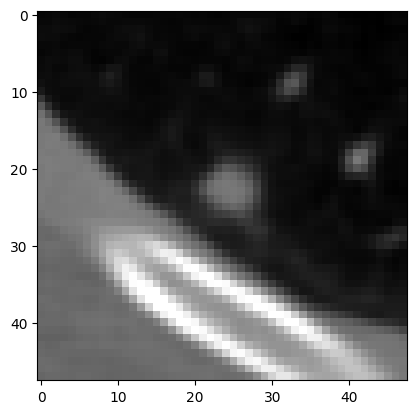

In [ ]:
# Visualize the nodule
import matplotlib.pyplot as plt
plt.imshow(ct_chunk[16, :, :], cmap='gray')
plt.show()

In [ ]:
# Create a new dataset with equal numbers of positives and negatives.
num_negatives = 2500
num_positives = 100
num_copies = 25

negative_chunks = torch.zeros([num_negatives, 32, 48, 48])
negative_labels = torch.zeros([num_negatives])

# Write Your Code Here

all_files = glob.glob('subset0/*.mhd')

count = 0

for file in all_files:

    # Load the file as an array
    ct_mhd = sitk.ReadImage(file)
    ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
    ct_a = ct_a.clip(-1000, 1000, ct_a)

    # Extract the ID from the file name.
    start_index = file.find('1.')
    end_index = file.find('.mhd')
    id = file[start_index:end_index]

    # for each CT scan load negative nodules from it.
    negative_nodules = data[(data['seriesuid'].str.contains(id)) & (data['class'] == 0)]

    # Loop through these nodules and create a subarray for each one.
    # We no longer need to reload the CT scan file.
    for nodule_index in negative_nodules.index:
        # Extract the indices for the center
        index, row, col = data.loc[nodule_index, ["index", "row", "col"]]

        # Build a 32x48x48 tensor to represent the nodule.
        # We need to add 0s if the nodule is too close to the boundary
        ct_chunk = torch.zeros([32, 48, 48])
        chunk = ct_a[(index-16):(index+16), (row-24):(row+24), (col-24):(col+24)]
        chunk_indices, chunk_rows, chunk_cols = chunk.shape
        ct_chunk[:chunk_indices, :chunk_rows, :chunk_cols] = torch.tensor(chunk)

        # Add this 3D tensor to the 4D tensor.
        negative_chunks[count, :, :, :] = ct_chunk

        # Add the corresponding label to the label tensor
        negative_labels[count] = 0

        count += 1
        print(count)
        if count == num_negatives - 1:
            break # break out of the inner loop
    if count == num_negatives - 1:
        break # break out of the outer loop

print(negative_chunks.shape, negative_labels.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
from torchvision.transforms.v2 import RandomAffine

positive_chunks = torch.zeros([num_positives * num_copies, 32, 48, 48])
positive_labels = torch.zeros([num_positives * num_copies])

# Write Your Code Here
shift_fn = RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10)

count = 0

for file in all_files:

    # Load the file as an array
    ct_mhd = sitk.ReadImage(file)
    ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
    ct_a = ct_a.clip(-1000, 1000, ct_a)

    # Extract the ID from the file name.
    start_index = file.find('1.')
    end_index = file.find('.mhd')
    id = file[start_index:end_index]

    # for each CT scan load negative nodules from it.
    positive_nodules = data[(data['seriesuid'].str.contains(id)) & (data['class'] == 1)]

    # Loop through these nodules and create a subarray for each one.
    # We no longer need to reload the CT scan file.
    for nodule_index in positive_nodules.index:
        # Extract the indices for the center
        index, row, col = data.loc[nodule_index, ["index", "row", "col"]]

        # Build a 32x48x48 tensor to represent the nodule.
        # We need to add 0s if the nodule is too close to the boundary
        ct_chunk = torch.zeros([32, 48, 48])
        chunk = ct_a[(index-16):(index+16), (row-24):(row+24), (col-24):(col+24)]
        chunk_indices, chunk_rows, chunk_cols = chunk.shape
        ct_chunk[:chunk_indices, :chunk_rows, :chunk_cols] = torch.tensor(chunk)

        # Add this 3D tensor to the 4D tensor.
        positive_chunks[count, :, :, :] = ct_chunk

        # Add the corresponding label to the label tensor
        positive_labels[count] = 1

        count += 1
        print(count)

        # Augmentation: Add 24 copies of the nodule after random affine modifications
        for j in range(1, 25):
            shifted_chunk = shift_fn(ct_chunk)
            positive_chunks[num_positives * j + count, :, :, :] = shifted_chunk
            positive_labels[num_positives * j + count] = 1

        if count == num_positives - 1:
            break # break out of the inner loop
    if count == num_positives - 1:
        break # break out of the outer loop

print(positive_chunks.shape, positive_labels)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
torch.Size([2500, 32, 48, 48]) tensor([1., 1., 1.,  ..., 1., 1., 1.])


In [ ]:
# Combine the two sets of instances
chunks = torch.cat([negative_chunks, positive_chunks], dim=0)
labels = torch.hstack([negative_labels, positive_labels])
print(chunks.shape, labels.shape)

torch.Size([5000, 32, 48, 48]) torch.Size([5000])


6.2 Retrain the neural network model on the new training set.

In [ ]:
# Use the balanced dataset to train the previous model.

chunks_train, chunks_test, labels_train, labels_test = train_test_split(chunks, labels, test_size=0.2)
print(chunks_train.shape, labels_train.shape)
print(chunks_test.shape, labels_test.shape)

# Turn the dataset into a dataloader
dataset = torch.utils.data.TensorDataset(chunks_train, labels_train)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                           shuffle=True)

torch.Size([4000, 32, 48, 48]) torch.Size([4000])
torch.Size([1000, 32, 48, 48]) torch.Size([1000])


In [ ]:
learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

In [ ]:
n_epochs = 50

for epoch in range(n_epochs):
    for img, label in train_loader:
        out = model(img)
        loss = loss_fn(out, label.long()) # label.long() represents the 0/1 labels as long integers

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 2295551.500000
Epoch: 1, Loss: 1536436.750000
Epoch: 2, Loss: 2322723.250000
Epoch: 3, Loss: 1479075.250000
Epoch: 4, Loss: 18264178.000000
Epoch: 5, Loss: 7662563.500000
Epoch: 6, Loss: 567045.875000
Epoch: 7, Loss: 1234859.125000
Epoch: 8, Loss: 3390010.750000
Epoch: 9, Loss: 586291.375000
Epoch: 10, Loss: 297341.750000
Epoch: 11, Loss: 771766.125000
Epoch: 12, Loss: 5693500.500000
Epoch: 13, Loss: 770382.625000
Epoch: 14, Loss: 4372369.500000
Epoch: 15, Loss: 77221.617188
Epoch: 16, Loss: 710102.250000
Epoch: 17, Loss: 2602982.500000
Epoch: 18, Loss: 1146939.000000
Epoch: 19, Loss: 3603947.000000
Epoch: 20, Loss: 1017183.937500
Epoch: 21, Loss: 940125.875000
Epoch: 22, Loss: 1960957.500000
Epoch: 23, Loss: 2943963.750000
Epoch: 24, Loss: 3615526.500000
Epoch: 25, Loss: 195450.187500
Epoch: 26, Loss: 1995530.000000
Epoch: 27, Loss: 173706.937500
Epoch: 28, Loss: 94165.046875
Epoch: 29, Loss: 1430418.500000
Epoch: 30, Loss: 656636.812500
Epoch: 31, Loss: 22100172.00000

6.3 Perform model evaluation and compare the performance of the new model to the old model.

In [ ]:
dataset = torch.utils.data.TensorDataset(chunks_test, labels_test)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                           shuffle=True)

probabilities = model(chunks_test)
_, predictions = torch.max(probabilities, dim=1)
mat = confusion_matrix(labels_test, predictions)
print(mat)

[[484  16]
 [ 42 458]]


In [ ]:
acc = accuracy_score(labels_test, predictions)
precision = precision_score(labels_test, predictions)
recall = recall_score(labels_test, predictions)
print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.942
Precision: 0.9662447257383966
Recall: 0.916


In [ ]:
# This new model have better accuracy, precision and recall